<a href="https://colab.research.google.com/github/rodrigoamorimml/NaturalLanguageProcessing/blob/master/ToxicCommentClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook it'll be used  the Kaggle Dataset Jig-Saw Toxic Comment for classification task, where can be found at: [Toxic Comment Dataset](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge)

This dataset contains  differents types of toxic comments and the task it's to classify this comments in six possibles categories. Since a  single comment can be placed in more than one category, then it'll be used 6 binary classification to complete this task.

In addition it will be used different types of architeture of neural networks to compare their performance and accuracy in this dataset, like a feed foward neural network (MLP), ConvNet and a Reccurent Neural Network.

Besides that, for the pre processing stage it will be used a Pre-trained Word Embedding Vector that can be download at: [Glove Embedding Vector](http://nlp.stanford.edu/data/glove.6B.zip)

In [ ]:
# Import Libraries

import os, sys

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Embedding, LSTM, SimpleRNN, GRU
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# First, using the link above, we download the jig-saw dataset, then we can open using the pandas dataframe :

from google.colab import files

upload = files.upload()


Saving train.csv to train.csv


In [ ]:
data = pd.read_csv('train.csv')
data.head(5)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [ ]:
# The dataset contains 159571 rows (comments) and 8 columns, where the second column represents the toxic comments
## and the next 6 columns represents the possible labels classification. So we will be using the comment text as our input
## and the six categories as our labels

data.shape

(159571, 8)

In [ ]:
# First we check if has any NaN Values
data.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [ ]:
labels = ['toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate']

X = data['comment_text'].values # get as numpy array
y = data[labels].values

print(f'Shape of Input Data: {X.shape}')
print(f'Shape of Output Data: {y.shape}')

Shape of Input Data: (159571,)
Shape of Output Data: (159571, 6)


In [ ]:
# The next step is load the Word Embedding Vector,  Word Embedding Vector are a class of techniques where individual words are represented as 
# real - value vector in a predefined vector space. Each word is mapped to one vector and the vector values are learned in a way that resembles
# a neural network. This dense distibuted representation is learned based on usage of words, this allows words that are used in similar ways to
# result in having similar representations, hence, capting their meaning.

# For this notebook we will use Glove (Global Vectors for Word Representation)


In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2020-07-30 13:45:54--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-07-30 13:45:54--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-07-30 13:45:54--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [ ]:
import zipfile

with zipfile.ZipFile('glove.6B.zip') as f:
  f.extractall()

In [ ]:
# Load the pre-trained word vector

EMBEDDING_DIM = 100 # we use the glove 100D

word2vec = {}

with open('glove.6B.%sd.txt' % EMBEDDING_DIM, encoding= 'utf-8') as f:
  for line in f:
    vector = line.split() # we first split into a list
    word = vector[0]  # the first position represents the word, and the rest the vector value
    word_vector = np.array(vector[1:], dtype = 'float32')
    word2vec[word] = word_vector

print(f'the number of words in the vector: {len(word2vec)}')

the number of words in the vector: 400000


In [ ]:
# the word2vec representation for a certain word show as a vector with 100 numbers to represent : 
word2vec['the']

array([-0.038194, -0.24487 ,  0.72812 , -0.39961 ,  0.083172,  0.043953,
       -0.39141 ,  0.3344  , -0.57545 ,  0.087459,  0.28787 , -0.06731 ,
        0.30906 , -0.26384 , -0.13231 , -0.20757 ,  0.33395 , -0.33848 ,
       -0.31743 , -0.48336 ,  0.1464  , -0.37304 ,  0.34577 ,  0.052041,
        0.44946 , -0.46971 ,  0.02628 , -0.54155 , -0.15518 , -0.14107 ,
       -0.039722,  0.28277 ,  0.14393 ,  0.23464 , -0.31021 ,  0.086173,
        0.20397 ,  0.52624 ,  0.17164 , -0.082378, -0.71787 , -0.41531 ,
        0.20335 , -0.12763 ,  0.41367 ,  0.55187 ,  0.57908 , -0.33477 ,
       -0.36559 , -0.54857 , -0.062892,  0.26584 ,  0.30205 ,  0.99775 ,
       -0.80481 , -3.0243  ,  0.01254 , -0.36942 ,  2.2167  ,  0.72201 ,
       -0.24978 ,  0.92136 ,  0.034514,  0.46745 ,  1.1079  , -0.19358 ,
       -0.074575,  0.23353 , -0.052062, -0.22044 ,  0.057162, -0.15806 ,
       -0.30798 , -0.41625 ,  0.37972 ,  0.15006 , -0.53212 , -0.2055  ,
       -1.2526  ,  0.071624,  0.70565 ,  0.49744 , 

In [ ]:
# Now we pass to the pre processing step, we need to transform this comments first splitting every word and then turning to integers for latter use as input 
# to the neural network, this phase can be done using the Tokenizer from keras

# Some configurations to use in our model
MAX_VOCAB_SIZE = 20000   # Is a value that can be well represented
MAX_SEQUENCE_LENGTH = 100

tokenizer = Tokenizer(num_words = MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(X)
x_seq = tokenizer.texts_to_sequences(X)
x_pad = pad_sequences(x_seq, maxlen = MAX_SEQUENCE_LENGTH) # We use the pad sequences, to pad all values into the same lenght (Samples x Length) Matrix
print(x_pad.shape)



(159571, 100)


In [ ]:
# To use the embedding vector, we need to indetify the words in our example to their respective values in the embedding matrix

word2idx = tokenizer.word_index
print(f'Number of unique words {len(word2idx)}')

num_words = min(MAX_VOCAB_SIZE, len(word2idx) + 1) # 

Number of unique words 210337


In [ ]:
# Next we need to create a embedding matrix to put this words with the respective values 

embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))

for word, i in word2idx.items():
  if i < num_words:
    embedding_vector = word2vec.get(word) # we take the values of the respective word in the embedding matrix
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector # put the word with their vector values in the specific index
    

print(embedding_matrix.shape)  # We have 20000 words with 100 values to represent

(20000, 100)


In [ ]:
# Next we load the pre-trained word embedding into a embedding layer, so we can use the keras api for neural networks

embedding_layer = Embedding(
    num_words,  # Vocab size
    EMBEDDING_DIM, # Embedding dimension
    input_length = MAX_SEQUENCE_LENGTH, 
    weights = [embedding_matrix],
    trainable = False # We set to false so we keep the embedding pre trained values fixed
)

In [ ]:
# Now We build our model, In this first case we will be using Convolutional Neural Network (1D) 

i = Input(shape = x_pad[0].shape) # We use the Max_sequence_length as our input_shape
x = embedding_layer(i)

x = Conv1D(128, 3, activation = 'relu')(x)  # We use 128 as a map of features, and a kernel size of 3
x = MaxPooling1D(3)(x)
x = Conv1D(128, 3, activation = 'relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(128, 3, activation = 'relu')(x)
x = GlobalMaxPooling1D()(x)  # We use globalmaxpooling to flatten the  maximum values


x = Dense(128, activation = 'relu')(x)
x = Dense(6, activation = 'sigmoid')(x) # we use an output of 6 = 6 possible categories in our dataset
                                        # and a activation function equals to sigmoid (6 binary classifications)
model = Model(i, x)                            

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 100, 100)          2000000   
_________________________________________________________________
conv1d (Conv1D)              (None, 98, 128)           38528     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 32, 128)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 30, 128)           49280     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 10, 128)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 8, 128)            49280 

In [48]:
# For our dataset we will be splitting our variables into train and validation set using the keras parameter Validation_split = 0.2

model.compile(loss = 'binary_crossentropy',
              optimizer = 'adam',
              metrics = ['acc'])

r = model.fit(x_pad, y, batch_size = 128, epochs = 10, validation_split = 0.2)

Epoch 1/10
998/998 [==============================] - 7s 7ms/step - loss: 0.0224 - acc: 0.8996 - val_loss: 0.1252 - val_acc: 0.9011
Epoch 2/10
998/998 [==============================] - 7s 7ms/step - loss: 0.0207 - acc: 0.8809 - val_loss: 0.1347 - val_acc: 0.9272
Epoch 3/10
998/998 [==============================] - 7s 7ms/step - loss: 0.0196 - acc: 0.8630 - val_loss: 0.1390 - val_acc: 0.8577
Epoch 4/10
998/998 [==============================] - 7s 7ms/step - loss: 0.0183 - acc: 0.8699 - val_loss: 0.1544 - val_acc: 0.7783
Epoch 5/10
998/998 [==============================] - 7s 7ms/step - loss: 0.0177 - acc: 0.8252 - val_loss: 0.1465 - val_acc: 0.8882
Epoch 6/10
998/998 [==============================] - 7s 7ms/step - loss: 0.0170 - acc: 0.8614 - val_loss: 0.1576 - val_acc: 0.8515
Epoch 7/10
998/998 [==============================] - 7s 7ms/step - loss: 0.0161 - acc: 0.8691 - val_loss: 0.1654 - val_acc: 0.8068
Epoch 8/10
998/998 [==============================] - 7s 7ms/step - loss: 0.

In [52]:
np.array(r.history['val_acc']).sum() / 10 
# We archive 86% of accuracy in the validation set

0.8609243333339691

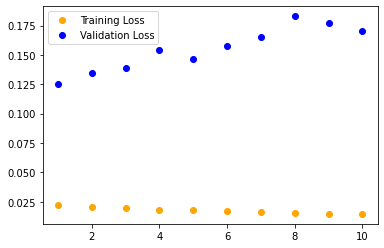

In [67]:
# We can see after 10 epochs we obtain 


epochs = (range(1, len(r.history['loss']) +1) )

plt.plot(epochs, r.history['loss'], 'bo', label = 'Training Loss', color = 'orange')
plt.plot(epochs, r.history['val_loss'], 'bo', label = 'Validation Loss')
plt.legend(loc = 'best')
plt.show()


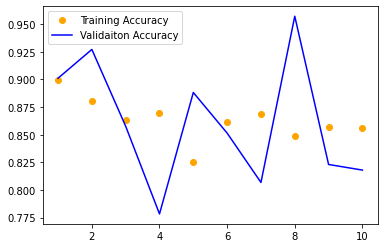

In [64]:
plt.plot(epochs, r.history['acc'], 'bo',  label = 'Training Accuracy',  color = 'orange')
plt.plot(epochs, r.history['val_acc'], 'b', label = 'Validaiton Accuracy', )
plt.legend(loc = 'best')
plt.show()